    Name: Arturo Perez 
    Email: arturo.e.perez@vanderbilt.edu
    VUnet: perezae
    Course: CS 3891 
    Date: 22 March 2018 

# 0. Helper Functions
We begin this assignment by defining the activation functions we will use later on. These include ReLU, Sigmoid, and their respective derivatives when applicable.

In [20]:
#   ReLU activation function
def ReLU (array):
    return np.maximum(0, array)
    
#   derivative of ReLU activation function
def dReLU(array):
    array[array < 0] = 0
    array[array > 0] = 1
    return array

#   Sigmoid activation function
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

We continue by defining a checkAccuracy function that will calculate our accuracy and error rates of our learning models.

In [21]:
#   compute the training and the test error
def checkAccuracy(w, b , X, Y, T, neuralnetworkType) :
    # initialize our paramters for use in forward propogation 
    z = [None] * len(w)
    a = [None] * len(w)

    # forward propopgation 
    # we use a[-1] (the a from the very last layer) to get our prediction labels
    z[0] = w[0] @ X + b[0]
    for i in range(len(w)-1):
        a[i] = ReLU(z[i])
        z[i+1] = w[i+1] @ a[i] + b[i+1]
    a[-1] = sigmoid(z[-1])

    # get the prediction labels  
    result = np.where(a[-1] >= 0.5, 1.0, 0.0)

    # compare our prediction labels to the actual labels (Y in this case)
    dim = result.ndim
    count = 0
    if (dim == 1) :
        for i in range(1, Y.size):
            if result[i] == Y[0, i]:
                count += 1
    else :       
        for i in range(1, Y.size):
            if result[0, i] == Y[0, i]:
                count += 1

    # calculate accuracy and error rates 
    accuracy = (count/Y.shape[1]) * 100
    error_rate = 100 - accuracy

    # print results 
    print(T + " accuracy rate for " + neuralnetworkType + " is : " + str(accuracy) + "%")
    print(T + " error rate for " + neuralnetworkType + " is : " + str(error_rate) + "%")
    print(" ")

## 1. Preprocessing 
###### In this section we take care of preprocessing the MNIST data set.
We start by reading in the MNIST data set. We seperate the training and testing data into 4 buffers.

In [22]:
import os, sys
import numpy as np
import struct
from scipy.special import expit
import matplotlib.pyplot as plt
from mnist import MNIST
import functools
from mlxtend.preprocessing import shuffle_arrays_unison


# the training set is stored in this directory
path = "/Users/Arturo1/Desktop/Vanderbilt/2017-2018/Spring 2018/Deep Learning 3891/handwriting"

# load the MNIST data
mndata = MNIST(path)
train_images, train_labels = mndata.load_training() # training data
test_images, test_labels = mndata.load_testing() # testing data

We continue by reshaping/rescaling the images and labels of both the training and test data.

In [23]:
# convert to (28x28,1) column vector and divide by 255
training_size, test_size = 60000, 10000   

train_images = np.array(train_images[:training_size], dtype=float).transpose() / 255
train_labels = np.array(train_labels[:training_size], dtype=float)
test_images = np.array(test_images[:test_size], dtype=float).transpose() / 255
test_labels = np.array(test_labels[:test_size], dtype = float)
train_labels = np.reshape(train_labels, (training_size, 1))
test_labels = np.reshape(test_labels, (test_size, 1))

# subset of 10,000 samples
subsetX = train_images[:,10000:20000]
subsetY = train_labels[10000:20000,:]

Because we want to predict whether a new image is equal to ID or not, we change the labels from train_labels and test_labels to be either 1 if they are equal to ID, or 0 if they are not. This will help us make our predictions later on and calculate the accuracy/error rates. In my case, ID is equal to 6. 

In [24]:
# student ID
ID = 6
# change the labels to either 0 or 1
def relabel(label):
    for l in label:
        if (l[0] == ID):
            l[0] = 1
        else:
            l[0] = 0
            
relabel(train_labels)
relabel(test_labels)

## 2. Minibatch SGD 
Now we train a 3-layer neural to classify the data using minibatch SGD. We plot the cost function, as well as calculate the training and test error. 

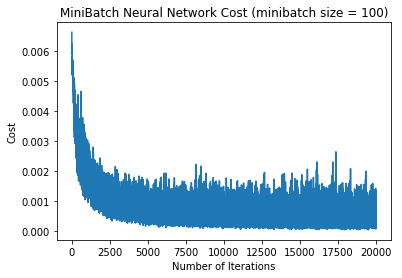

Train accuracy rate for Minibatch Neural Network is : 98.61%
Train error rate for Minibatch Neural Network is : 1.3900000000000006%
 
Test accuracy rate for Minibatch Neural Network is : 98.44000000000001%
Test error rate for Minibatch Neural Network is : 1.559999999999988%
 


In [25]:
# helper function to get the next minibatch from the data
def getNextMiniBatch(X, Y, batchSize) :
    for i in range(0, X.shape[1], batchSize) :
        yield (X[: , i:i + batchSize] , Y[:, i:i + batchSize ])

def minibatchNeuralNetwork(p, q, alpha, batchSize, layer_list):
    f, m = p.shape
    
    # initialize weights, biases and parameters 
    w = functools.reduce(lambda acc, neurons: (acc[0] + [np.random.randn(neurons, 
    acc[1]) * np.sqrt(2.0/acc[1])], neurons), layer_list, ([], f))[0]
    b = [ np.random.randn(neurons, 1) * 0.01 for neurons in layer_list ]
    z = [None] * len(w)
    a = [None] * len(w)
    costs = []

    for i in range(0, 200):
        # api function call used to shuffle 2 numpy arrays in unison
        p, q = shuffle_arrays_unison(arrays=[p.T, q.T], random_seed=3)
        p = p.T
        q = q.T

        # for each minibatch: forward prop, compute cost, backward prop, update parameters
        for X, Y in getNextMiniBatch(p, q, batchSize) :
            # forward propopgation
            z[0] = w[0] @ X + b[0]
            for i in range(len(w)-1):
                a[i] = ReLU(z[i])
                z[i+1] = w[i+1] @ a[i] + b[i+1]
            a[-1] = sigmoid(z[-1])

            # compute cost
            cost = - (Y @ np.log(a[-1].T) + (1 - Y) @ np.log(1 - a[-1].T))[0,0] / m
            costs.append(cost)

            dZ = a[-1] - Y
            gradients = [] 
            
            # backward propogation 
            for k in range(len(z)-2, -1, -1):
                # Calculate dW and DB
                gradients.append([ (dZ @ a[k].T) / m, 
                    np.sum(dZ, axis=1).reshape(b[k+1].shape) / m ])
            
                dZ = (w[k+1].T @ dZ) * dReLU(z[k])

            # Calculate dW and dB for the first layer
            gradients.append([ (dZ @ X.T) / m, 
                np.sum(dZ, axis=1).reshape(b[0].shape) / m ])

            # flip gradients so order is from first to last layer
            gradients = gradients[::-1]

            # update parameters 
            for j in range(len(gradients)):
                w[j] = w[j] - (alpha * gradients[j][0])
                b[j] = b[j] - (alpha * gradients[j][1])
            
    # plot cost function
    plt.clf()
    plt.plot(costs)
    plt.title("MiniBatch Neural Network Cost (minibatch size = " + str(batchSize) + ")")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost")
    plt.show()
    return(w, b)
 
    

layers = [20, 10]
# learning rate = .1, minibatch size = 100
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .1, 100, layers)
neuralType = "Minibatch Neural Network"
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

### Investigation of the minibatch size
In general by increasing the batch size, we start getting a smoother and decreasing cost function (the largest batchsize with a size of 5000 had the most "normal" cost function). Another noticable difference between small and large batches was small batches took more time to compute than their large batch counterparts. Changing the batch size has a negligible effect on accuracy rates. 

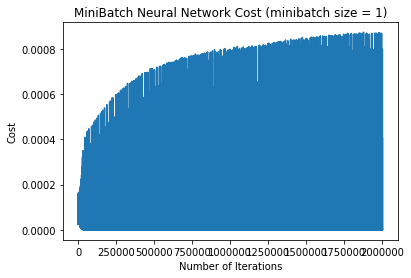

Train accuracy rate for Minibatch Neural Network is : 98.61%
Train error rate for Minibatch Neural Network is : 1.3900000000000006%
 
Test accuracy rate for Minibatch Neural Network is : 98.45%
Test error rate for Minibatch Neural Network is : 1.5499999999999972%
 


In [26]:
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .1, 1, layers)
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

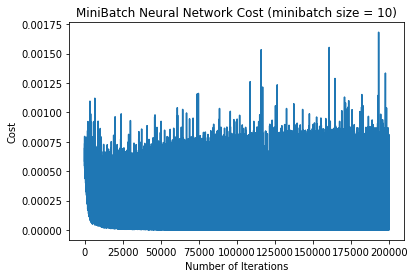

Train accuracy rate for Minibatch Neural Network is : 98.61%
Train error rate for Minibatch Neural Network is : 1.3900000000000006%
 
Test accuracy rate for Minibatch Neural Network is : 98.45%
Test error rate for Minibatch Neural Network is : 1.5499999999999972%
 


In [27]:
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .1, 10, layers)
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

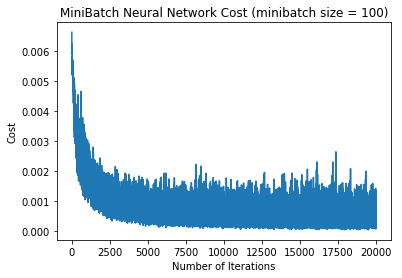

Train accuracy rate for Minibatch Neural Network is : 98.61%
Train error rate for Minibatch Neural Network is : 1.3900000000000006%
 
Test accuracy rate for Minibatch Neural Network is : 98.44000000000001%
Test error rate for Minibatch Neural Network is : 1.559999999999988%
 


In [28]:
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .1, 100, layers)
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

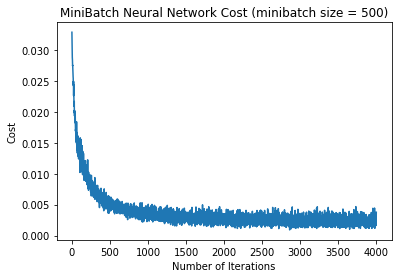

Train accuracy rate for Minibatch Neural Network is : 98.61%
Train error rate for Minibatch Neural Network is : 1.3900000000000006%
 
Test accuracy rate for Minibatch Neural Network is : 98.44000000000001%
Test error rate for Minibatch Neural Network is : 1.559999999999988%
 


In [29]:
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .1, 500, layers)
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

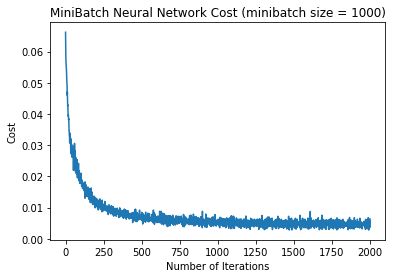

Train accuracy rate for Minibatch Neural Network is : 98.61999999999999%
Train error rate for Minibatch Neural Network is : 1.3800000000000097%
 
Test accuracy rate for Minibatch Neural Network is : 98.45%
Test error rate for Minibatch Neural Network is : 1.5499999999999972%
 


In [30]:
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .1, 1000, layers)
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

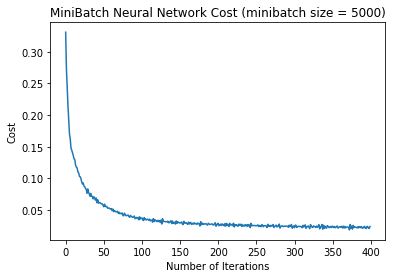

Train accuracy rate for Minibatch Neural Network is : 98.68%
Train error rate for Minibatch Neural Network is : 1.3199999999999932%
 
Test accuracy rate for Minibatch Neural Network is : 98.44000000000001%
Test error rate for Minibatch Neural Network is : 1.559999999999988%
 


In [31]:
w,b = minibatchNeuralNetwork(subsetX, subsetY.T, .1, 5000, layers)
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

## 3. Minibatch SGD with Momentum
Now we train a 3-layer neural to classify the data using minibatch SGD with momentum. We plot the cost function, as well as calculate the training and test error. 

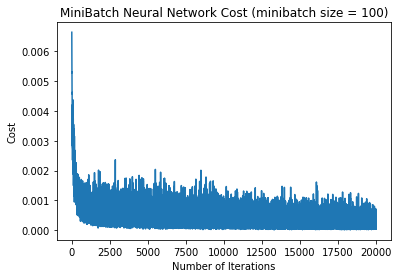

momentum parameter = .1
Train accuracy rate for Minibatch Neural Network with Momentum is : 99.25%
Train error rate for Minibatch Neural Network with Momentum is : 0.75%
 
Test accuracy rate for Minibatch Neural Network with Momentum is : 98.72%
Test error rate for Minibatch Neural Network with Momentum is : 1.2800000000000011%
 


In [34]:
def minibatchWithMomentum(p, q, epsilon, alpha, batchSize, layer_list):
    f, m = p.shape
    
    # initialize weights, biases and parameters 
    w = functools.reduce(lambda acc, neurons: (acc[0] + [np.random.randn(neurons, 
    acc[1]) * np.sqrt(2.0/acc[1])], neurons), layer_list, ([], f))[0]
    b = [ np.random.randn(neurons, 1) * 0.01 for neurons in layer_list ]
    Vb = [ np.zeros((neurons, 1)) for neurons in layer_list ]
    z = [None] * len(w)
    a = [None] * len(w)
    costs = []

    newLayerList = [f]
    for i in range (0, len(layer_list)) :
        newLayerList.append(layer_list[i])
    newLayerList.append(1)

    Vw = [0] * len(newLayerList)
    for i in range (1, len(newLayerList)) :
        Vw[i-1] = np.zeros((newLayerList[i], newLayerList[i-1]))

    for i in range(0, 200):
        # api function used to shuffle 2 numpy arrays in unison
        p, q = shuffle_arrays_unison(arrays=[p.T, q.T], random_seed=3)
        p = p.T
        q = q.T

        # for each minibatch: forward prop, compute cost, backward prop, update parameters
        for X, Y in getNextMiniBatch(p, q, batchSize) :
            # forward propopgation
            z[0] = w[0] @ X + b[0]
            for i in range(len(w)-1):
                a[i] = ReLU(z[i])
                z[i+1] = w[i+1] @ a[i] + b[i+1]
            a[-1] = sigmoid(z[-1])

            # compute cost
            cost = - (Y @ np.log(a[-1].T) + (1 - Y) @ np.log(1 - a[-1].T))[0,0] / m
            costs.append(cost)

            dZ = a[-1] - Y
            gradients = [] 
            # backward propogation 
            for k in range(len(z)-2, -1, -1):
                # Calculate dW and DB
                gradients.append([ (dZ @ a[k].T) / m, 
                    np.sum(dZ, axis=1).reshape(b[k+1].shape) / m ])
            
                dZ = (w[k+1].T @ dZ) * dReLU(z[k])

            # Calculate dW and dB for the first layer
            gradients.append([ (dZ @ X.T) / m, 
                np.sum(dZ, axis=1).reshape(b[0].shape) / m ])

            # flip gradients so order is from first to last layer
            gradients = gradients[::-1]

            # update parameters 
            for j in range(len(gradients)):
                Vw[j] = alpha*Vw[j] - epsilon*gradients[j][0]
                Vb[j] = alpha*Vb[j] - epsilon*gradients[j][1]
                w[j] = w[j] + Vw[j]
                b[j] = b[j] + Vb[j]
            
    # plot cost function
    plt.clf()
    plt.plot(costs)
    plt.title("MiniBatch Neural Network Cost (minibatch size = " + str(batchSize) + ")")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost")
    plt.show()
    return(w, b)
 
layers = [20, 10]
w,b = minibatchWithMomentum(subsetX, subsetY.T, .5, .1, 100, layers)
neuralType = "Minibatch Neural Network with Momentum"
print("momentum parameter = .1")
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

### Investigation of the momentum parameter 
In general by increasing the momentum parameter, our cost function starts to become smoother and less noisy. At very high values of the momentum parameter (such as greater than  0.7), the cost function even starts to become squashed and cost function values are pushed towards 0. The accuracy rates also tend to improve as the momentum parameter increases (started with 98.68% test accuracy for momentum = .01 and improved that to 98.99% test accuracy for momentum = .9)

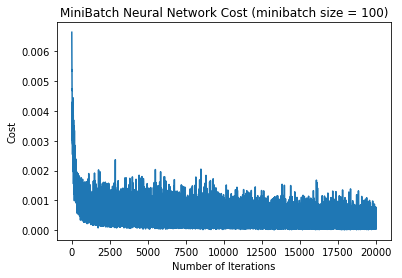

momentum parameter = .01
Train accuracy rate for Minibatch Neural Network with Momentum is : 99.18%
Train error rate for Minibatch Neural Network with Momentum is : 0.8199999999999932%
 
Test accuracy rate for Minibatch Neural Network with Momentum is : 98.68%
Test error rate for Minibatch Neural Network with Momentum is : 1.3199999999999932%
 


In [35]:
w,b = minibatchWithMomentum(subsetX, subsetY.T, .5, .01, 100, layers)
neuralType = "Minibatch Neural Network with Momentum"
print("momentum parameter = .01")
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

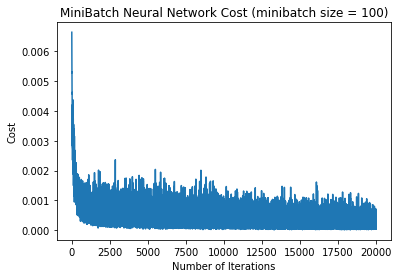

momentum parameter = .1
Train accuracy rate for Minibatch Neural Network with Momentum is : 99.25%
Train error rate for Minibatch Neural Network with Momentum is : 0.75%
 
Test accuracy rate for Minibatch Neural Network with Momentum is : 98.72%
Test error rate for Minibatch Neural Network with Momentum is : 1.2800000000000011%
 


In [36]:
w,b = minibatchWithMomentum(subsetX, subsetY.T, .5, .1, 100, layers)
neuralType = "Minibatch Neural Network with Momentum"
print("momentum parameter = .1")
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

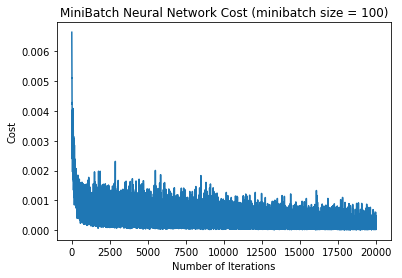

momentum parameter = .3
Train accuracy rate for Minibatch Neural Network with Momentum is : 99.56%
Train error rate for Minibatch Neural Network with Momentum is : 0.4399999999999977%
 
Test accuracy rate for Minibatch Neural Network with Momentum is : 98.87%
Test error rate for Minibatch Neural Network with Momentum is : 1.1299999999999955%
 


In [37]:
w,b = minibatchWithMomentum(subsetX, subsetY.T, .5, .3, 100, layers)
neuralType = "Minibatch Neural Network with Momentum"
print("momentum parameter = .3")
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

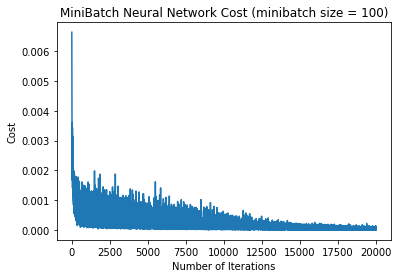

momentum parameter = .7
Train accuracy rate for Minibatch Neural Network with Momentum is : 99.98%
Train error rate for Minibatch Neural Network with Momentum is : 0.01999999999999602%
 
Test accuracy rate for Minibatch Neural Network with Momentum is : 98.99%
Test error rate for Minibatch Neural Network with Momentum is : 1.0100000000000051%
 


In [38]:
w,b = minibatchWithMomentum(subsetX, subsetY.T, .5, .7, 100, layers)
neuralType = "Minibatch Neural Network with Momentum"
print("momentum parameter = .7")
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)

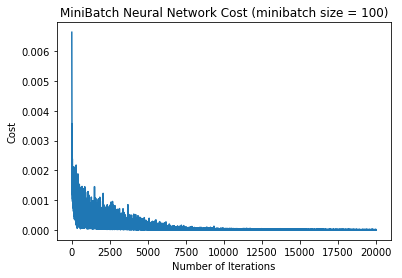

momentum parameter = .9
Train accuracy rate for Minibatch Neural Network with Momentum is : 99.99%
Train error rate for Minibatch Neural Network with Momentum is : 0.010000000000005116%
 
Test accuracy rate for Minibatch Neural Network with Momentum is : 98.97%
Test error rate for Minibatch Neural Network with Momentum is : 1.0300000000000011%
 


In [39]:
w,b = minibatchWithMomentum(subsetX, subsetY.T, .5, .9, 100, layers)
neuralType = "Minibatch Neural Network with Momentum"
print("momentum parameter = .9")
checkAccuracy(w, b, subsetX, subsetY.T, "Train", neuralType)
checkAccuracy(w, b, test_images, test_labels.T, "Test", neuralType)